In [1]:
import os
import sys
import random
import math
import re 
import time

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import imageio
import skimage
from config import Config
from skimage.morphology import label
from skimage.feature import canny
from skimage import exposure
from keras.callbacks import Callback
from skimage.morphology import binary_closing, binary_opening, disk, binary_dilation
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.externals import joblib
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.morphology import watershed
from skimage.filters import sobel

import utils
import model as modellib
import visualize
from model import log

/home/tianqi/anaconda3/envs/2018-data-science-bowl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/tianqi/anaconda3/envs/2018-data-science-bowl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.set_random_seed(127)
POSTPROCESS = False
AGGREGATE = False

In [3]:

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
class DsbConfig(Config):

    # Give the configuration a recognizable name
    NAME = "dsb"
      
    LEARNING_RATE = 1e-2
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution image
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Train on 1 GPU and 8 images per GPU. Batch size is GPUs * images/GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Total number of steps (batches of samples) to yield from generator 
    # before declaring one epoch finished and starting the next epoch.
    # typically be equal to the number of samples of your dataset divided by the batch size
    STEPS_PER_EPOCH = 660
    VALIDATION_STEPS = 70

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleis
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_PADDING = True  # currently, the False option is not supported
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels, maybe add a 256?
    
    BACKBONE = "resnet101"

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 400 #320
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]
    TRAIN_ROIS_PER_IMAGE = 512
    RPN_NMS_THRESHOLD = 0.7
    MAX_GT_INSTANCES = 256
    DETECTION_MAX_INSTANCES = 400 
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7 # may be smaller?
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3 # 0.3
    
    #MEAN_PIXEL = np.array([42.17746161,38.21568456,46.82167803])
    
    MEAN_PIXEL = np.array([0.,0.,0.])
    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    
    LEARNING_MOMENTUM=0.9
    
config = DsbConfig()
inference_config = DsbConfig()


In [5]:
import numpy as np # linear algebra

def rleToMask(rleString,height,width):
  rows,cols = height,width
  rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
  rlePairs = np.array(rleNumbers).reshape(-1,2)
  img = np.zeros(rows*cols,dtype=np.uint8)
  for index,length in rlePairs:
    index -= 1
    img[index:index+length] = 255
  img = img.reshape(cols,rows)
  img = img.T
  return img

class DsbDataset(utils.Dataset):
    def __init__(self, rle_df):
        super().__init__(self)
        self.rle_df = rle_df
        
    def load_dataset(self, dir_id_pairs, train_mode=True):
        self.add_class("dsb", 1, "nuclei")

        for i, (directory, id) in enumerate(dir_id_pairs):
            image_dir = os.path.join(directory, id)
            self.add_image("dsb", image_id=i, real_id=id, path=image_dir)
            

    def load_image(self, image_id, non_zero=None):
        info = self.image_info[image_id]
        path = info['path']
        #print(info['real_id'])
        image_name = os.listdir(os.path.join(path, 'images'))
        image_path = os.path.join(path, 'images', image_name[0])
        image = imageio.imread(image_path)
        if len(image.shape) == 2:
            image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        elif image.shape[2] > 3:
            image = image[:,:,:3]
        
        image = self.preprocess(image)
        image = image.astype('float32')
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        image = self.load_image(image_id)
        mask_shape = image.shape
        info = self.image_info[image_id]
        cur_rle = self.rle_df[self.rle_df['ImageId'] == info['real_id']]
        mask = []
        for i, row in cur_rle.iterrows():
            msk = rleToMask(row['EncodedPixels'],mask_shape[0],mask_shape[1])

            if np.sum(msk) == 0:
                print('invalid mask')
                continue
            msk = msk.astype('float32')/255.
            mask.append(msk)
        mask = np.asarray(mask)
        mask[mask > 0.] = 1.
        mask = np.transpose(mask, (1,2,0))
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        count = mask.shape[2]
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = [self.class_names.index('nuclei') for s in range(count)]
        class_ids = np.asarray(class_ids)
        return mask, class_ids.astype(np.int32)
    
    def preprocess(self, img):
        gray = skimage.color.rgb2gray(img.astype('uint8'))
        img = skimage.color.gray2rgb(gray)
        img *= 255.
        return img

In [6]:
dsb_dir = '/home/tianqi/gitlab/2018-data-science-bowl-me/terence/input/stage1_train'
valid_dir = '/home/tianqi/gitlab/2018-data-science-bowl-me/terence/input/stage1_test'
test_dir = '/home/tianqi/gitlab/2018-data-science-bowl-me/terence/input/stage2_test_final'
train_ids = os.listdir(dsb_dir)
valid_ids = os.listdir(valid_dir)
test_ids = os.listdir(test_dir)

In [7]:
train_pairs = [(dsb_dir, x) for x in train_ids]
valid_pairs = [(valid_dir, x) for x in valid_ids]
test_pairs = [(test_dir, x) for x in test_ids]
train_val_pairs = train_pairs+valid_pairs

In [8]:
label_train = pd.read_csv('/home/tianqi/gitlab/2018-data-science-bowl-me/terence/input/stage1_train_labels.csv')
label_valid = pd.read_csv('/home/tianqi/gitlab/2018-data-science-bowl-me/terence/input/stage1_solution.csv')
label_stage1 = pd.concat([label_train[['ImageId','EncodedPixels']],
           label_valid[['ImageId','EncodedPixels']]], ignore_index=True)

In [9]:
from sklearn.model_selection import train_test_split

train_idx, valid_idx = train_test_split(list(range(len(train_val_pairs))), test_size=0.1, random_state=42)
train_pairs_, valid_pairs_ = [train_val_pairs[i] for i in train_idx], [train_val_pairs[i] for i in valid_idx]

In [10]:
# Training dataset
dataset_train = DsbDataset(label_stage1)
dataset_train.load_dataset(train_pairs_)
dataset_train.prepare()

# Validation dataset
dataset_val = DsbDataset(label_stage1)
dataset_val.load_dataset(valid_pairs_)
dataset_val.prepare()

# Test dataset
dataset_test = DsbDataset(label_stage1)
dataset_test.load_dataset(test_pairs, train_mode=False)
dataset_test.prepare()

In [11]:

model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [12]:
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [13]:
model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE,
                epochs=3, 
                layers="heads")


Starting at epoch 0. LR=0.01

Checkpoint Path: /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDist

/home/tianqi/anaconda3/envs/2018-data-science-bowl/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/tianqi/anaconda3/envs/2018-data-science-bowl/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/3
660/660 [==============================] - 273s 414ms/step - loss: 1.6578 - rpn_class_loss: 0.1275 - rpn_bbox_loss: 0.7828 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.2823 - val_loss: 1.4209 - val_rpn_class_loss: 0.0917 - val_rpn_bbox_loss: 0.6660 - val_mrcnn_class_loss: 0.1827 - val_mrcnn_bbox_loss: 0.2348 - val_mrcnn_mask_loss: 0.2459
Epoch 2/3
660/660 [==============================] - 266s 403ms/step - loss: 1.2992 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.6396 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2336 - val_loss: 1.4047 - val_rpn_class_loss: 0.0793 - val_rpn_bbox_loss: 0.6389 - val_mrcnn_class_loss: 0.1982 - val_mrcnn_bbox_loss: 0.2244 - val_mrcnn_mask_loss: 0.2639
Epoch 3/3
660/660 [==============================] - 264s 401ms/step - loss: 1.2713 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.6190 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.1900 - mrcnn_mask_loss: 0.2341 - val_loss: 1.2743 - val_rpn_c

In [14]:
model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE,
                epochs=6, 
                layers="all")


Starting at epoch 3. LR=0.01

Checkpoint Path: /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a    

/home/tianqi/anaconda3/envs/2018-data-science-bowl/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/tianqi/anaconda3/envs/2018-data-science-bowl/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 4/6
660/660 [==============================] - 318s 481ms/step - loss: 1.0852 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.4361 - mrcnn_class_loss: 0.1444 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.2537 - val_loss: 0.9877 - val_rpn_class_loss: 0.0404 - val_rpn_bbox_loss: 0.3604 - val_mrcnn_class_loss: 0.1359 - val_mrcnn_bbox_loss: 0.1996 - val_mrcnn_mask_loss: 0.2514
Epoch 5/6
660/660 [==============================] - 310s 470ms/step - loss: 0.9385 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.3497 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.2421 - val_loss: 0.9700 - val_rpn_class_loss: 0.0630 - val_rpn_bbox_loss: 0.2980 - val_mrcnn_class_loss: 0.1660 - val_mrcnn_bbox_loss: 0.1729 - val_mrcnn_mask_loss: 0.2701
Epoch 6/6
660/660 [==============================] - 310s 470ms/step - loss: 0.8479 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.3018 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.2291 - val_loss: 1.0101 - val_rpn_c

In [15]:
model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE/10,
                epochs=15, 
                layers="all")


Starting at epoch 6. LR=0.001

Checkpoint Path: /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a   

/home/tianqi/anaconda3/envs/2018-data-science-bowl/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/tianqi/anaconda3/envs/2018-data-science-bowl/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 7/15
660/660 [==============================] - 318s 482ms/step - loss: 0.7458 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.2347 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2265 - val_loss: 0.7954 - val_rpn_class_loss: 0.0286 - val_rpn_bbox_loss: 0.2398 - val_mrcnn_class_loss: 0.1398 - val_mrcnn_bbox_loss: 0.1478 - val_mrcnn_mask_loss: 0.2393
Epoch 8/15
660/660 [==============================] - 310s 470ms/step - loss: 0.6995 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.1347 - mrcnn_mask_loss: 0.2201 - val_loss: 0.8007 - val_rpn_class_loss: 0.0279 - val_rpn_bbox_loss: 0.2504 - val_mrcnn_class_loss: 0.1281 - val_mrcnn_bbox_loss: 0.1561 - val_mrcnn_mask_loss: 0.2381
Epoch 9/15
660/660 [==============================] - 311s 471ms/step - loss: 0.6524 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1859 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2185 - val_loss: 0.8145 - val_rp

In [16]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0015.h5


In [12]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = '/home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0015.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0015.h5


In [18]:
model_folder = model_path[:-21]
model_paths = []
for filename in os.listdir(model_folder):
    if filename[-2:] == 'h5':
        model_paths.append(model_folder+filename)
        
other_models = []
for model_path in model_paths:
    other_model = modellib.MaskRCNN(mode="inference", 
                              config=inference_config,
                              model_dir=MODEL_DIR)

    # Get path to saved weights
    # Either set a specific path or find last trained weights

    #model_path = model.find_last()[1]

    # Load trained weights (fill in path to trained weights here)
    assert model_path != "", "Provide path to trained weights"
    print("Loading weights from ", model_path)
    other_model.load_weights(model_path, by_name=True)
    other_models.append(other_model)

Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0015.h5
Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0005.h5
Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0007.h5
Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0004.h5
Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0002.h5
Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-bowl/code_submission0408/code_submission/logs/dsb20180412T2309/mask_rcnn_dsb_0003.h5
Loading weights from  /home/tianqi/Documents/Kaggle/2018-data-science-

In [13]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (512, 512, 3)         min:    1.00000  max:  254.00000
image_meta               shape: (10,)                 min:    0.00000  max:  512.00000
gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (13, 4)               min:    0.00000  max:  512.00000
gt_mask                  shape: (512, 512, 13)        min:    0.00000  max:    1.00000


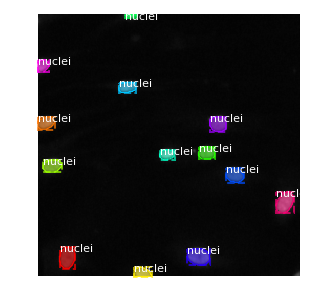

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  254.00000
molded_images            shape: (1, 512, 512, 3)      min:    1.00000  max:  254.00000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


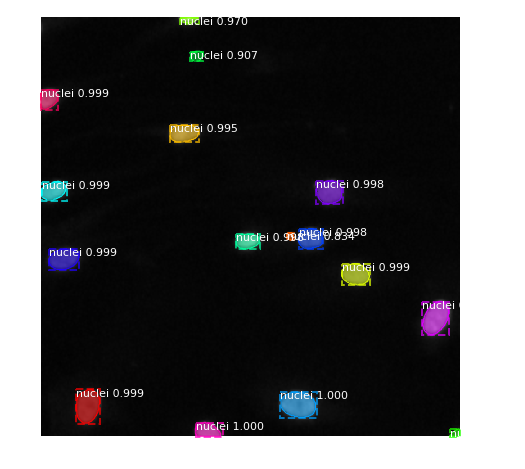

In [14]:
image_id = random.choice(dataset_val.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(5, 5))

results = model.detect([original_image]*config.IMAGES_PER_GPU, verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(), figsize=(5, 5) )


In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 65)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image]*config.IMAGES_PER_GPU, verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))


mAP:  0.8492432229684381


In [16]:
from tqdm import tqdm
def calc_iou(img1, img2):
    denom = np.sum((img1+img2)>0)
    if denom==0:
        return 0

    return np.sum(img1*img2)/denom

def is_intersect(roi1, roi2):
    if roi1[0] > roi2[2] or roi1[2] < roi2[0]:
        return False
    if roi1[1] > roi2[3] or roi1[3] < roi2[1]:
        return False
    return True

zero_count=0
if not AGGREGATE:
    raw_predictions = []
    for test_id in tqdm(dataset_test.image_ids):
        test_image1 = dataset_test.load_image(test_id, 0)
        pred = model.detect([test_image1], verbose=0)
        pred = pred[0]
        sc = pred['scores']
        pred = pred['masks']
        raw_predictions.append((pred, sc))
        if(pred.shape[0]==0):
            zero_count += 1
else:
    raw_predictions = []
    for test_id in tqdm(dataset_test.image_ids):
        test_image1 = dataset_test.load_image(test_id, 0)
        
        pred = model.detect([test_image1], verbose=0)
        pred = pred[0]
        sc = pred['scores']
        if len(sc) == 0:
            continue
        this_rois = pred['rois']
        pred = pred['masks']

        #print(pred.shape)
        aggregate_masks = pred.copy()
        for jj in range(pred.shape[2]):
            mask = pred[:,:,jj]
            aggregate_masks[:,:,jj] = mask
            this_roi = this_rois[jj]

            for other_model in other_models:
                other_pred = other_model.detect([test_image1], verbose=0)[0]
                other_masks = other_pred['masks']
                other_rois = other_pred['rois']
                if len(other_pred['scores']==0) or len(other_rois)==0 or other_masks.shape[0] == 0:
                    continue
                    
                cur_iou = 0
                cur_id = -1
                for i in range(other_masks.shape[2]):
                    #print(this_roi, other_rois[i])
                    try:
                        if not is_intersect(this_roi, other_rois[i]):
                            #print("continue")
                            continue
                    except Exception as e:
                        print(e)
                        print('imageid: ', test_id)
                        print(other_masks.shape, len(other_rois))
                        continue
                        

                    cand_iou = calc_iou(mask, other_masks[:,:,i])
                    if cand_iou > cur_iou:
                        cur_iou = cand_iou
                        cur_id = i
                if cur_id >= 0:
                    aggregate_masks[:,:,jj] += other_masks[:,:,cur_id]

            aggregate_masks[:,:,jj] = (aggregate_masks[:,:,jj] > 0.5*len(other_models))*1

        raw_predictions.append((aggregate_masks, sc))

100%|██████████| 3019/3019 [09:24<00:00,  5.35it/s]


In [17]:
zero_count

315

In [18]:

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [19]:

def numpy2encoding_no_overlap(predicts, img_name, scores):
    sum_predicts = np.sum(predicts, axis=2)
    rows, cols = np.where(sum_predicts>=2)
    
    for i in zip(rows, cols):
        instance_indicies = np.where(predicts[i[0],i[1],:])[0]
        
        #print(instance_indicies)
        highest = instance_indicies[np.argmax(scores[instance_indicies])]
        #print(scores[instance_indicies])
        #print(highest)
        predicts[i[0],i[1],:] = predicts[i[0],i[1],:]*0
        predicts[i[0],i[1],highest] = 1
    
    ImageId = []
    EncodedPixels = []
    #print(predicts.shape)
    for i in range(predicts.shape[2]): 
        rle = rle_encoding(predicts[:,:,i])
        if len(rle)>0:
            ImageId.append(img_name)
            EncodedPixels.append(rle)    
    return ImageId, EncodedPixels

In [20]:
def filter_small(multi_mask, threshold):
    num_masks = int(multi_mask.max())

    j=0
    for i in range(num_masks):
        thresh = (multi_mask==(i+1))

        area = thresh.sum()
        if area < threshold:
            multi_mask[thresh]=0
        else:
            multi_mask[thresh]=(j+1)
            j = j+1

    return multi_mask

In [21]:
new_test_ids = []
rles = []

counter=0
for id, raw_pred in zip(test_ids, raw_predictions):
    if counter % 100 == 0:
        print(counter)
    counter += 1
    raw_pred_0 = raw_pred[0]
    raw_pred_1 = raw_pred[1]
    if POSTPROCESS:
        raw_pred_0 = filter_small(raw_pred_0, 8)
    ids, rle = numpy2encoding_no_overlap(raw_pred_0, id, raw_pred_1)
    new_test_ids += ids
    rles += rle

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


In [22]:
len_diff = len((set(test_ids) - set(new_test_ids)))
df = pd.DataFrame({ 'ImageId' : new_test_ids+list(set(test_ids) - set(new_test_ids)) , 
                   'EncodedPixels' : rles + [[]]*len_diff})
df['EncodedPixels'] = df['EncodedPixels'].apply(lambda x: ' '.join(str(y) for y in x))
df.to_csv('submission_0416_fancy.csv', index=False, columns=['ImageId', 'EncodedPixels'])

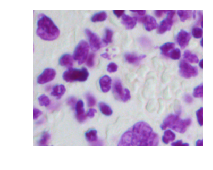

In [29]:
thisid = df.sample(1).ImageId.values[0]
fname = test_dir+'/'+thisid+\
'/images/'+thisid+'.png'

img = skimage.io.imread(fname)
visualize.display_images([img])

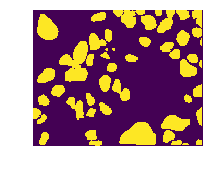

In [30]:
imgs = df[df['ImageId']==thisid]['EncodedPixels'].apply(lambda x: rleToMask(x,img.shape[0],img.shape[1]))
visualize.display_images([imgs.sum()])